```
• Feature Selection: Employ chi-squared tests to identify significant lin-
guistic features.
• Regression Analysis: Analyze correlations using regression to predict
sentiment shifts.
• Validation: Cross-validate results to ensure reliability and replicability.
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from torch.utils.data import DataLoader, Dataset
import torch

# import tensorflow

In [2]:
file_name = os.path.join(os.getcwd(),  'sentiment_analysis.csv')
df = pd.read_csv(file_name)
df = df.drop(columns=['id'])
df.head()

,label,tweet
0,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,0,Finally a transparant silicon case ^^ Thanks t...
2,0,We love this! Would you go? #talk #makememorie...
3,0,I'm wired I know I'm George I was made that wa...
4,1,What amazing service! Apple won't even talk to...


In [3]:
def clean(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    # text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'\n',' ', text)  # Remove line breaks
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)  # Remove punctuation
    text = text.lower()  # Lowercase

    filtered_text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])

    return filtered_text

# Function to extract hashtags from a tweet
def extract_hashtags(tweet):
    hashtags = re.findall(r'#(\w+)', tweet)
    return hashtags

# Apply the function to extract hashtags and create a new column
#df['hashtags'] = df['tweet'].apply(extract_hashtags)

#df['cleaned_tweet'] = df['tweet'].apply(clean)

In [4]:
!pip install textblob
import nltk
#download the necessary nltk data
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/aidan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /home/aidan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
from nltk.corpus import stopwords
from textblob import TextBlob

In [6]:
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

def get_pos_tags(text):
    tokens = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    return tags

# Applying the transformations
df['cleaned_tweet'] = df['tweet'].apply(clean)
df['hashtags'] = df['tweet'].apply(extract_hashtags)
df['sentiment_polarity'], df['sentiment_subjectivity'] = zip(*df['cleaned_tweet'].apply(get_sentiment))
df['pos_tags'] = df['cleaned_tweet'].apply(get_pos_tags)

print(df.head())

   label                                              tweet  \
0      0  #fingerprint #Pregnancy Test https://goo.gl/h1...   
1      0  Finally a transparant silicon case ^^ Thanks t...   
2      0  We love this! Would you go? #talk #makememorie...   
3      0  I'm wired I know I'm George I was made that wa...   
4      1  What amazing service! Apple won't even talk to...   

                                       cleaned_tweet  \
0  fingerprint pregnancy test android apps beauti...   
1  finally transparant silicon case thanks uncle ...   
2  love talk makememories unplug relax iphone sma...   
3  im wired know im george way iphone cute davent...   
4  amazing service apple wont talk question unles...   

                                            hashtags  sentiment_polarity  \
0  [fingerprint, Pregnancy, android, apps, beauti...               0.675   
1               [yay, Sony, Xperia, S, sonyexperias]               0.100   
2  [talk, makememories, unplug, relax, iphone, sm...    

In [7]:
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

In [8]:
print(df.columns)
# Feature Extraction with CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=5, ngram_range=(1,2))
X = vectorizer.fit_transform(df['cleaned_tweet'])

# Assuming 'target' is your sentiment/category column
label_enc = LabelEncoder()
df['target_encoded'] = label_enc.fit_transform(df['label'])

# Feature Selection with Chi-squared
chi2_features = SelectKBest(chi2, k=100)
X_kbest_features = chi2_features.fit_transform(X, df['target_encoded'])

# Dimensionality Reduction with PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_kbest_features.toarray())  # Scaling is important for PCA

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Dimensionality Reduction with LDA
# Ensure the number of components for LDA does not exceed the number of classes minus one
lda = LDA(n_components=min(len(label_enc.classes_)-1, X_kbest_features.shape[1]))
X_lda = lda.fit_transform(X_kbest_features.toarray(), df['target_encoded'])

# Output some results
print("Selected features:", vectorizer.get_feature_names_out()[chi2_features.get_support()])
print("PCA reduced features to:", pca.n_components_)
print("LDA reduced features to:", lda.n_components)

Index(['label', 'tweet', 'cleaned_tweet', 'hashtags', 'sentiment_polarity',
       'sentiment_subjectivity', 'pos_tags'],
      dtype='object')
Selected features: ['amazing' 'apple' 'apple products' 'battery' 'beautiful' 'birthday'
 'broken' 'case' 'charger' 'chargers' 'cute' 'dear apple' 'deleted'
 'didnt' 'does' 'doesnt' 'dont' 'fashion' 'fix' 'follow' 'follow follow'
 'follow rts' 'followers' 'followers rt' 'fuck' 'fuck apple' 'fucked'
 'fucking' 'fuckyou' 'fuckyou apple' 'fun' 'funny' 'gain' 'gain followers'
 'gain iphone' 'girl' 'going' 'half' 'happy' 'hate' 'hate apple'
 'hateapple' 'hour' 'hours' 'igers' 'instagood' 'instagram' 'ios'
 'ipad iphone' 'iphone' 'iphone sougofollow' 'iphoneonly' 'iphonesia'
 'iphonex' 'ipod' 'itunes' 'ive' 'just' 'life' 'lost' 'love' 'need' 'new'
 'news' 'pay' 'phone' 'photo' 'photography' 'photooftheday' 'pissed'
 'really' 'restore' 'right' 'rt' 'rt follow' 'rts' 'rts gain' 'samsung'
 'selfie' 'seriously' 'shit' 'shitty' 'smile' 'software' 'sony'
 '

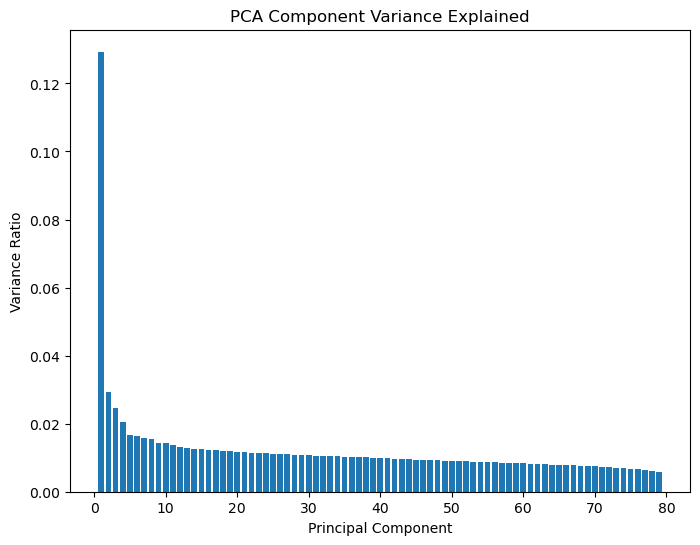

In [9]:
# PCA Variance Explained Plot
pca_explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca_explained_variance)+1), pca_explained_variance)
plt.ylabel('Variance Ratio')
plt.xlabel('Principal Component')
plt.title('PCA Component Variance Explained')
plt.show()

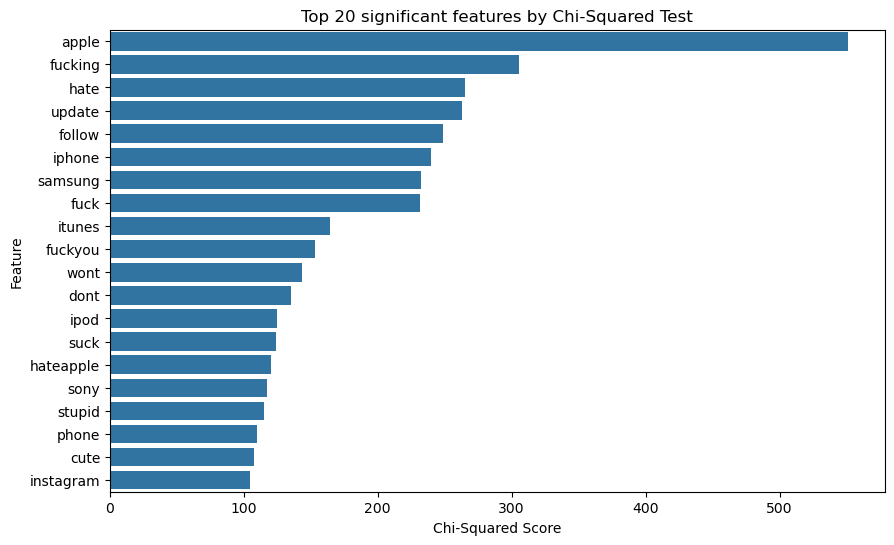

In [10]:
# Visualization of Chi-Squared Feature Importances
import matplotlib.pyplot as plt

scores = chi2_features.scores_
features = vectorizer.get_feature_names_out()

# Create a DataFrame to hold feature names and their corresponding scores
features_scores = pd.DataFrame({'Feature': features, 'Score': scores})
features_scores = features_scores.sort_values(by='Score', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=features_scores['Score'], y=features_scores['Feature'], orient='h')
plt.title('Top 20 significant features by Chi-Squared Test')
plt.xlabel('Chi-Squared Score')
plt.ylabel('Feature')
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
X = X_pca  # or X_lda, depending on which you want to use
y = df['sentiment_polarity']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.06973530078086079
R^2 Score: 0.3288582444282965


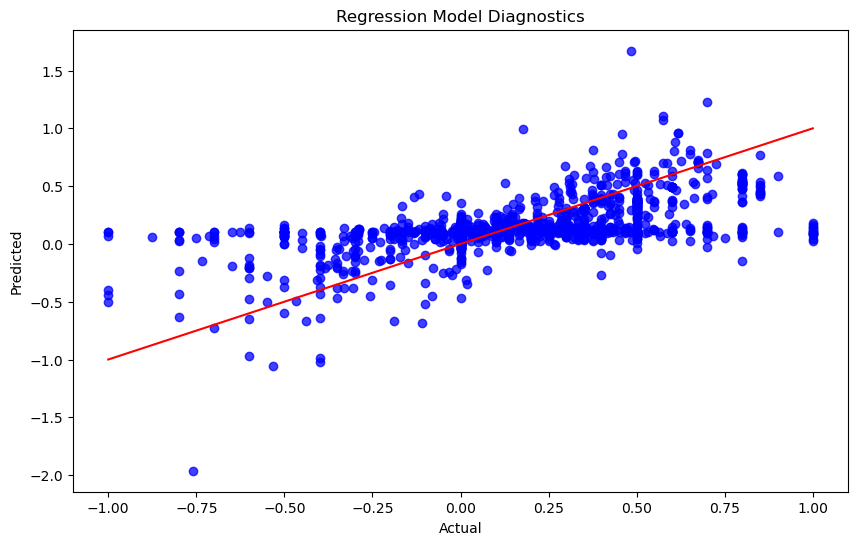

In [12]:
# Regression Diagnostics Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.75, color='b')  # Plotting the actual vs predicted values
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Regression Model Diagnostics')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # A reference line
plt.show()

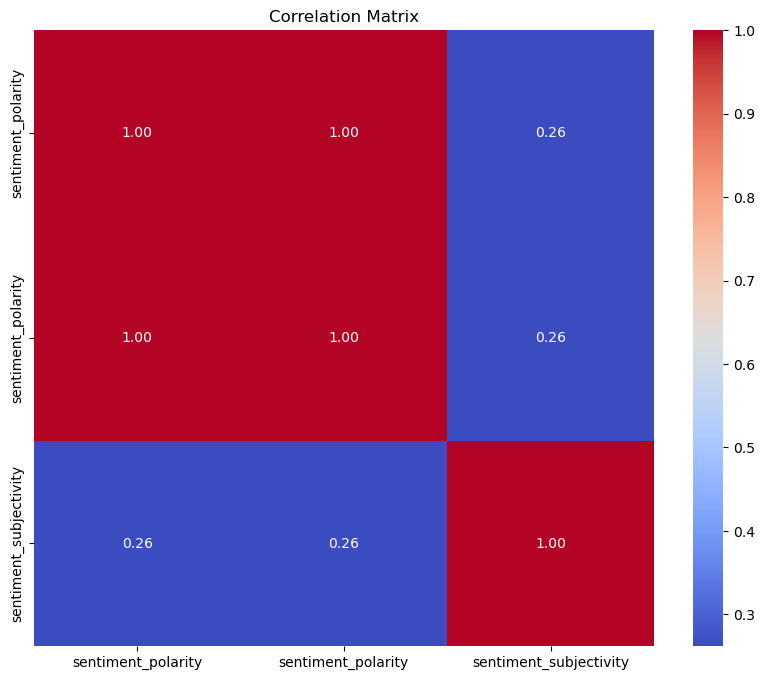

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame where columns include 'sentiment_polarity' and other numeric features
# Let's create a smaller DataFrame with only relevant features for simplicity
feature_columns = ['sentiment_polarity'] + list(df.columns[df.dtypes == 'float64'])  # modify this as necessary

# Calculate correlation matrix
corr_matrix = df[feature_columns].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Assuming the target variable 'label' is categorical and already encoded into 'target_encoded'
X = X_pca
y = df['target_encoded']  # This should be a binary or multi-class categorical variable

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression Model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Making predictions
y_pred = logistic_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Logistic Regression Model Evaluation:")
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

Logistic Regression Model Evaluation:
Accuracy: 0.8478535353535354
Confusion Matrix:
[[1093   59]
 [ 182  250]]
